# Create JRA55-do forcing for CICE6
This code is mostly taken from [this official CICE script](https://github.com/NoahDay-2/CICE/blob/2025.01/configuration/tools/jra55_datasets/interp_jra55_ncdf_bilinear.py) as well as compatibility with Gadi from [this script](https://github.com/aekiss/notebooks/blob/master/JRA55-do-interpolation.ipynb).

In [1]:
import xesmf as xe
from netCDF4 import Dataset
import argparse
import os
import numpy as np
from datetime import datetime
from dask.distributed import Client
import re
from tqdm.notebook import tqdm

# Other Method

In [2]:
client = Client(threads_per_worker=1, memory_limit=0)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37381,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45969,Total threads: 1
Dashboard: /proxy/36521/status,Memory: 0 B
Nanny: tcp://127.0.0.1:35579,


In [4]:
def JRA55_regridder(grid_in, grid_out, method='bilinear', **kwargs): # based on https://nbviewer.jupyter.org/github/aekiss/ice_analysis/blob/main/ice_maps.ipynb
    '''Return a function that takes one dataarray argument on grid_in and returns that dataarray regridded onto grid_out.
    
    grid_in -- path to a JRA55-do NetCDF grid file
    grid_out -- path to a MOM grid file (U points are used)
    '''
    match = re.search(r'global\.(.*?)/', grid_out)
    if match:
        resolution = match.group(1)
        
    fn = f'{resolution}_U_grid_{method}.nc'
    weightfn = os.path.join("/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-1deg/atmosphere/JRA55-do/1-4-0/8XDAILY/regridders", fn)
    # print(weightfn)
    #'_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
               #          'to', os.path.splitext(os.path.basename(grid_out))[0], 'U', 'grid', method])+'.nc'
    ds_in = xr.open_dataset(grid_in).rename({'lat': 'y', 'lon': 'x'})

    ds_in = ds_in.isel(time=0).drop_vars(['time_bnds', 'lat_bnds'], errors='ignore')

    # Now drop the coordinate 'time' if it still exists
    if 'time' in ds_in.coords:
        ds_in = ds_in.drop_vars('time')
    
    # Finally, drop the 'bnds' dimension if it's no longer needed
    if 'bnds' in ds_in.dims:
        ds_in = ds_in.drop_dims('bnds')

    # ds_in
    #.drop_vars('prsn')
    #.rename({'ni': 'x', 'nj': 'y', 'tlon': 'lon', 'tlat': 'lat'})
    # try: # for /g/data/ik11/grids/ocean_grid_10.nc and /g/data/ik11/grids/ocean_grid_025.nc
    ds_out = xr.open_dataset(grid_out).rename({'ni': 'x', 'nj': 'y', 'tlon': 'lon', 'tlat': 'lat'})
    # except ValueError: # for /g/data/ik11/grids/ocean_grid_01.nc - see https://github.com/COSIMA/access-om2/issues/236
    #     ds_out = xr.open_dataset(grid_out).rename({'ni': 'x', 'nj': 'y', 'tlon': 'lon', 'tlat': 'lat'})
    #     # ds_out_fix = xr.open_dataset('/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output000/ocean/ocean-3d-u-1-monthly-mean-ym_1958_01.nc')\
    #                 # .rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
    #     ds_out = ds_out.assign_coords({'x': grid_out['x'], 'y': grid_out['y']})

    print(ds_in)
    print(ds_out)
    # make regridder
    rg = xe.Regridder(ds_in, ds_out, method=method, periodic = True, 
                      reuse_weights=False,#os.path.exists(weightfn), 
                      filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da)
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        return outds.rename({'x': 'ni', 'y': 'nj', 'lon': 'LON', 'lat': 'LAT'})

    return outf




## 📥 Input Cell: Define Your Inputs

In [5]:
ds_in = xr.open_dataset("/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/atmos/3hr/prsn/gr/v20190429/prsn_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_201901010130-201901052230.nc")
# ds_in.isel(time=0).drop_vars(['time', 'time_bnds', 'lat_bnds', 'bnds'])

ds_in = ds_in.isel(time=0).drop_vars(['time_bnds', 'lat_bnds'], errors='ignore')

# Now drop the coordinate 'time' if it still exists
if 'time' in ds_in.coords:
    ds_in = ds_in.drop_vars('time')

# Finally, drop the 'bnds' dimension if it's no longer needed
if 'bnds' in ds_in.dims:
    ds_in = ds_in.drop_dims('bnds')

ds_in

<xarray.Dataset> Size: 827kB
Dimensions:  (lat: 320, lon: 640)
Coordinates:
  * lat      (lat) float64 3kB -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * lon      (lon) float64 5kB 0.0 0.5625 1.125 1.688 ... 358.3 358.9 359.4
Data variables:
    prsn     (lat, lon) float32 819kB ...
Attributes: (12/36)
    Conventions:         CF-1.7 CMIP-6.2
    activity_id:         input4MIPs
    cell_measures:       area: areacella
    comment:             Based on JRA-55 reanalysis (1958-01 to 2019-01)
    contact:             Hiroyuki Tsujino (htsujino@mri-jma.go.jp)
    creation_date:       2019-03-08T07:30:54Z
    ...                  ...
    target_mip:          OMIP
    title:               MRI JRA55-do 1.4.0 dataset prepared for input4MIPs
    tracking_id:         hdl:21.14100/0b9ee372-d110-446a-8320-987c63c34ac7
    variable_id:         prsn
    license:             OMIP boundary condition data produced by MRI is lice...
    cmor_version:        3.4.0

In [6]:
def load_cice_grid_with_degrees(
    input_path='/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc',
    # drop_vars=('ulat', 'ulon', 'htn', 'hte', 'angle', 'angleT', 'tarea', 'uarea'),
    chunks={'ny': -1, 'nx': -1}
):
    """
    Load a CICE grid file and convert lon/lat from radians to degrees.

    Parameters
    ----------
    input_path : str
        Path to the input CICE grid file.
    chunks : dict
        Dask chunk sizes.

    Returns
    -------
    xr.Dataset
        Modified dataset with lon/lat in degrees.
    """
    ds = xr.open_dataset(input_path, chunks=chunks)
    
    lon_rad = ds.tlon
    lat_rad = ds.tlat
    
    ds['tlon'] = np.rad2deg(lon_rad)
    ds['tlat'] = np.rad2deg(lat_rad)
    
    # ds = ds.drop(('tlon', 'tlat'))
    
    # ds['lon'].attrs['units'] = 'degrees_east'
    # ds['lat'].attrs['units'] = 'degrees_north'

    ds = ds.rename({'ni': 'x', 'nj': 'y', 'tlon': 'lon', 'tlat': 'lat'})
    
    return ds

ds_out = load_cice_grid_with_degrees("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc")
ds_out


ds_out# ['lat'].values

<xarray.Dataset> Size: 9MB
Dimensions:  (y: 300, x: 360)
Coordinates:
    ulat     (y, x) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    ulon     (y, x) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    lat      (y, x) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    lon      (y, x) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    htn      (y, x) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    hte      (y, x) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    angle    (y, x) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    anglet   (y, x) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    tarea    (y, x) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    uarea    (y, x) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    crs      |S1 1B ...
Attributes:
    Conventions:  CF-1.6
    inputfile:    /g/data/vk83/experiments/inputs/access-om3/mom/grids/mosaic...
    history:      Created using https://github.com/COSIMA/esmgrids 0.1.1: cic...

In [211]:
# '_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
#                          'to', os.path.splitext(os.path.basename(grid_out))[0], 'U', 'grid', method])+'.nc'

In [212]:
# grid_in = "/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/atmos/3hrPt/uas/gr/v20190429/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_195801010000-195812312100.nc"
# grid_out = "/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc"
# method = "conservative"

In [213]:
%%time
# Define inputs manually instead of from command-line args
# JRADTG = "2021010100"  # Example date-time group
# dstgrid = "/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc"  # Path to CICE destination grid
# ncout = "output_jra55_forcing.nc"  # Output NetCDF filename


# Define functions to regrid JRA55-do wind data onto each ACCESS-OM2 
JRA55file = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/atmos/3hrPt/uas/gr/v20190429/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_195801010000-195812312100.nc'
JRAto1deg = JRA55_regridder(JRA55file, "/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc", method='patch')
# JRAto025deg = JRA55_regridder(JRA55file, '/g/data/ik11/grids/ocean_grid_025.nc', method='patch')
# JRAto01deg = JRA55_regridder(JRA55file, '/g/data/ik11/grids/ocean_grid_01.nc', method='patch')



<xarray.Dataset> Size: 827kB
Dimensions:  (y: 320, x: 640)
Coordinates:
  * y        (y) float64 3kB -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * x        (x) float64 5kB 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4
    height   float64 8B ...
Data variables:
    uas      (y, x) float32 819kB ...
Attributes: (12/36)
    Conventions:         CF-1.7 CMIP-6.2
    activity_id:         input4MIPs
    cell_measures:       area: areacella
    comment:             Based on JRA-55 reanalysis (1958-01 to 2019-01)
    contact:             Hiroyuki Tsujino (htsujino@mri-jma.go.jp)
    creation_date:       2019-03-07T11:47:59Z
    ...                  ...
    target_mip:          OMIP
    title:               MRI JRA55-do 1.4.0 dataset prepared for input4MIPs
    tracking_id:         hdl:21.14100/1641886a-45c6-4611-9eac-6a4fa0d5884b
    variable_id:         uas
    license:             OMIP boundary condition data produced by MRI is lice...
    cmor_version:        3.4.0
<xarray.Data

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 2920, bnds: 2, y: 320, x: 640)
Coordinates:
  * time       (time) datetime64[ns] 23kB 1958-01-01 ... 1958-12-31T21:00:00
  * y          (y) float64 3kB -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * x          (x) float64 5kB 0.0 0.5625 1.125 1.688 ... 358.3 358.9 359.4
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 47kB ...
    lat_bnds   (y, bnds) float64 5kB ...
    lon_bnds   (x, bnds) float64 10kB ...
    uas        (time, y, x) float32 2GB ...
Attributes: (12/36)
    Conventions:         CF-1.7 CMIP-6.2
    activity_id:         input4MIPs
    cell_measures:       area: areacella
    comment:             Based on JRA-55 reanalysis (1958-01 to 2019-01)
    contact:             Hiroyuki Tsujino (htsujino@mri-jma.go.jp)
    creation_date:       2019-03-07T11:47:59Z
    ...                  ...
    target_mip:          OMIP
    title:               MRI JRA55-do 1.4.0 dataset prepared for input4MIPs
    tracking_id:         hdl:21.14100/1641886a-45c6-4611-9eac-6a4fa0d5884b
    variable_id:         uas
    license:             OMIP boundary condition data produced by MRI is lice...
    cmor_version:        3.4.0

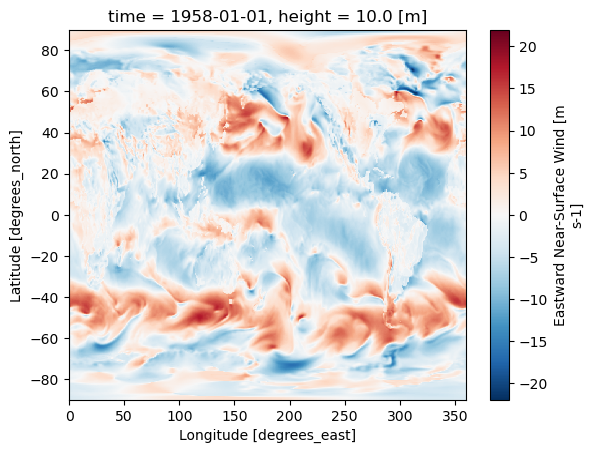

In [214]:
# os.path.splitext(os.path.basename(grid_out))[.]
# JRAto1deg
ds_JRA = xr.open_dataset(JRA55file).rename({'lat': 'y', 'lon': 'x'})
ds_JRA['uas'].isel(time=0).plot()

ds_JRA#.transpose()

CPU times: user 27.4 s, sys: 14.9 s, total: 42.3 s
Wall time: 34.8 s


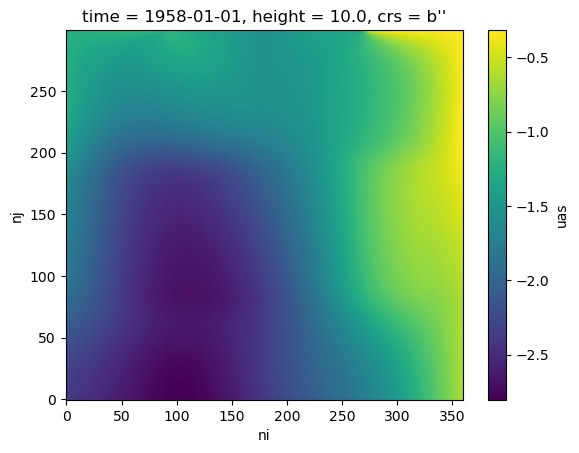

In [215]:
%%time
# u1deg = JRAto1deg(JRAu)
# JRAto1deg

ds_JRA_1deg = JRAto1deg(ds_JRA)
ds_JRA_1deg['uas'].isel(time=0).plot()

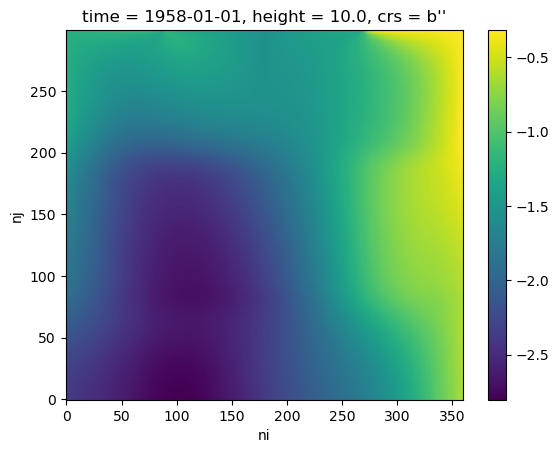

In [221]:
# session = cc.database.create_session()

JRAto1deg(ds_JRA.isel(time=0)['uas']).plot()

In [217]:
ds_JRA_1deg

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 2920, nj: 300, ni: 360)
Coordinates:
  * time     (time) datetime64[ns] 23kB 1958-01-01 ... 1958-12-31T21:00:00
    height   float64 8B ...
    ulat     (nj, ni) float64 864kB ...
    ulon     (nj, ni) float64 864kB ...
    LAT      (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.153 1.145 1.138
    LON      (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.395 1.396 1.396
    crs      |S1 1B ...
  * ni       (ni) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * nj       (nj) int64 2kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
Data variables:
    uas      (time, nj, ni) float32 1GB -2.395 -2.398 -2.401 ... -1.062 -1.073
Attributes:
    regrid_method:  patch

# CICE Method

In [3]:
def make_regridder(lon1, lat1, lon2, lat2, method, periodic, grdname,
                   lon1_b=None, lat1_b=None, lon2_b=None, lat2_b=None):
    '''
    make nearest neighbor xESMF regridder object.
    input:
    lon1: source longitudes (degrees)
    lat1: source latitudes  (degrees)
    lon2: target longitudes (degrees)
    lat2: target latitudes (degrees)
    method: regridding  method (bilinear, patch, conservative, nearest_s2d)
    periodic: True if periodic longitudes, false if not
    grdname: filename for regridder (Ugrid or Tgrid)
    '''
    if method != "conservative":
        # define grids for regridder
        grid1 = {'lon' : lon1, 'lat' : lat1}
        grid2 = {'lon' : lon2, 'lat' : lat2}


    else:
        # conservative needs boundary lon/lat
        grid1 = {'lon'   : lon1,   'lat'   : lat1,
                 'lon_b' : lon1_b, 'lat_b' : lat1_b}

        grid2 = {'lon'   : lon2,   'lat'   : lat2,
                 'lon_b' : lon2_b, 'lat_b' : lat2_b}

    # make regridder
    # here specify reuse_weights=False to re-generate weight file.
    # if wanted to reuse file inteas of making int, 
    # check if file exists and change use_file_weights=True. 
    # see commented out example below 
    use_file_weights=False

    # check if regrid file exists.
    # If so, reuse file instead of regenerating.
    # if (os.path.isfile(blin_grid_name)):
        # use_file_weights = True

    regridder = xe.Regridder(ds_in=grid1,ds_out=grid2,
                             method=method,
                             periodic=periodic,
                             filename=grdname,
                             reuse_weights=use_file_weights)


    return regridder

#########################################
#########################################


def halo_extrapolate(a,ew_bndy_type,ns_bndy_type):
    '''
    Extrapolate to 'halo' cell as in CICE code
    ice_boundary.F90:ice_HaloExtrapolate.
    inputs:
    a: array nx+1, ny+1 (nghost/nhalo hard-coded as 1 for now)
    ew_bndy_type: east/west boundary type (cyclic, regional, etc)
    ns_bndy_type: norh/south boundary type (cyclic, regional, etc)

    return: a with halo applied
    '''

    # get dimension of a
    # expected to be 0:nx+nghost, 0:ny+nghost
    nj, ni = a.shape # note with Python NetCDF is nj, ni order
    # W/E edges
    if ew_bndy_type == 'cyclic':
        a[: ,0] = a[:,-2] # -2, since -1 is ghost cell
        a[:,-1] = a[:, 1] #  1, since  0 is ghost cell
    else: # if (trim(ew_bndy_type) /= 'cyclic') then
        a[:, 0] = 2.0*a[:, 1] - a[:, 2]
        a[:,-1] = 2.0*a[:,-2] - a[:,-3]

    # south edge
    if ns_bndy_type == 'cyclic':
        a[0,:] = a[-2,:] # -2, since -1 is ghost cell
    else:
        a[0,:] = 2.0*a[1,:] - a[2,:]

    # north edge treated a little different, depending
    # on if bndy type is tripole
    if ns_bndy_type == 'cyclic':
        a[-1,:] = a[1,:] # 1, since 0 is ghost cell

    elif (ns_bndy_type != 'cyclic'  and
          ns_bndy_type != 'tripole' and
          ns_bndy_type != 'tripoleT'):

        a[-1,:] = 2.0*a[-2,:] - a[-3,:]

    else:
        pass # do nothing

    # return array with halo upated
    return a


#########################################
#########################################

def Tlatlon(ulat,ulon,ew_bndy_type,ns_bndy_type):
    '''
    Make TLAT/TLON from ULAT/ULON.
    see ice_grid.F90:Tlatlon for method
    Inputs:
    ulat: U grid latitude in degrees
    ulon: U grid longitude in degrees

    output:
    tlat in degrees
    tlon in degrees
    '''

    # method obtained from ice_grid.F90: subroutine Tlatlon
    ulatcos = np.cos(np.deg2rad(ulat))
    ulatsin = np.sin(np.deg2rad(ulat))

    uloncos = np.cos(np.deg2rad(ulon))
    ulonsin = np.sin(np.deg2rad(ulon))

    # initialize array with nghost=1 on each side
    nj, ni = ulatcos.shape # note: Python NetCDF is nj, ni order
    print("Tlatlon nj, ni", nj, ni)

    nghost     = 1
    workdims   = (nj+2*nghost,ni+2*nghost)
    #print("Tlatlon workdims", workdims)

    ulatcos1 = np.zeros(workdims,dtype='f8')
    ulatsin1 = np.zeros(workdims,dtype='f8')
    uloncos1 = np.zeros(workdims,dtype='f8')
    ulonsin1 = np.zeros(workdims,dtype='f8')

    # fill middle of work arrays
    ulatcos1[1:nj+1,1:ni+1] = ulatcos
    ulatsin1[1:nj+1,1:ni+1] = ulatsin

    # fill middle of work arrays
    ulatcos1[1:nj+1,1:ni+1] = ulatcos
    ulatsin1[1:nj+1,1:ni+1] = ulatsin

    uloncos1[1:nj+1,1:ni+1] = uloncos
    ulonsin1[1:nj+1,1:ni+1] = ulonsin

    # fill halos
    ulatcos1 = halo_extrapolate(ulatcos1,ew_bndy_type,ns_bndy_type)
    ulatsin1 = halo_extrapolate(ulatsin1,ew_bndy_type,ns_bndy_type)
    uloncos1 = halo_extrapolate(uloncos1,ew_bndy_type,ns_bndy_type)
    ulonsin1 = halo_extrapolate(ulonsin1,ew_bndy_type,ns_bndy_type)

    # now do computations as in ice_grid.F90:Tlatlon

    # x, y, z are full 2d
    x = uloncos1 * ulatcos1
    y = ulonsin1 * ulatcos1
    z = ulatsin1

    tx = 0.25*(x[0:nj,  0:ni  ]   + # x1
               x[0:nj,  1:ni+1]   + # x2
               x[1:nj+1,0:ni  ]   + # x3
               x[1:nj+1,1:ni+1])    # x4

    #print("Tlonlat: x.shape", x.shape)
    #print("Tlonlat: tx.shape", tx.shape)


    ty = 0.25*(y[0:nj,  0:ni  ]   + # y1
               y[0:nj,  1:ni+1]   + # y2
               y[1:nj+1,0:ni  ]   + # y3
               y[1:nj+1,1:ni+1])    # y4


    tz = 0.25*(z[0:nj,  0:ni  ]   + # z1
               z[0:nj,  1:ni+1]   + # z2
               z[1:nj+1,0:ni  ]   + # z3
               z[1:nj+1,1:ni+1])    # z4

    da = np.sqrt(tx*tx + ty*ty + tz*tz)

    tz = tz/da

    tlon = np.arctan2(ty,tx)
    tlat = np.arcsin(tz)

    # returnd tlat, tlon in degrees
    return np.rad2deg(tlat), np.rad2deg(tlon)


################################
################################


def get_jra55_nc_dict(version='1-4-0'):
    '''
    Create dictionary that links the NetCDF variable name
    with the file prefix. The file prefix is appended by 
    JRADTG from command line
    '''
    # specify dictionary with dataset prefix names 
    jra55dict = {"prsn" : f"prsn_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-{version}_gr_", # precip
                 "rsds" : f"rsds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-{version}_gr_", # downward shortwave
                 "rlds" : f"rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-{version}_gr_", # downward longwave
                 "tas"  : f"tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-{version}_gr_"   , # air temp
                 "uas"  : f"uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-{version}_gr_"  , # u velocity
                 "vas"  : f"vas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-{version}_gr_"  , # v velocity
                 "huss" : f"huss_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-{version}_gr_"}   # specify humidity

    
    return jra55dict

################################
################################


def get_jra55_path_dict(version='1-4-0'):
    '''
    Create dictionary that links the NetCDF variable name
    with the file prefix. The file prefix is appended by 
    JRADTG from command line
    '''
    # specify dictionary with dataset prefix names 
    if version == '1-6-0':
        folder = 'v20240531'
        cmip_folder = 'CMIP6Plus'
    elif version == '1-4-0':
        folder = 'v20190429'
        cmip_folder = 'CMIP6'
    else:
        raise ValueError("Incorrect version provided!")
       
        
    jra55dict = {"prsn" : f"/g/data/qv56/replicas/input4MIPs/{cmip_folder}/OMIP/MRI/MRI-JRA55-do-{version}/atmos/3hr/prsn/gr/{folder}", # precip
                 "rsds" : f"/g/data/qv56/replicas/input4MIPs/{cmip_folder}/OMIP/MRI/MRI-JRA55-do-{version}/atmos/3hr/rsds/gr/{folder}", # downward shortwave
                 "rlds" : f"/g/data/qv56/replicas/input4MIPs/{cmip_folder}/OMIP/MRI/MRI-JRA55-do-{version}/atmos/3hr/rlds/gr/{folder}", # downward longwave
                 "tas"  : f"/g/data/qv56/replicas/input4MIPs/{cmip_folder}/OMIP/MRI/MRI-JRA55-do-{version}/atmos/3hrPt/tas/gr/{folder}"   , # air temp
                 "uas"  : f"/g/data/qv56/replicas/input4MIPs/{cmip_folder}/OMIP/MRI/MRI-JRA55-do-{version}/atmos/3hrPt/uas/gr/{folder}"  , # u velocity
                 "vas"  : f"/g/data/qv56/replicas/input4MIPs/{cmip_folder}/OMIP/MRI/MRI-JRA55-do-{version}/atmos/3hrPt/vas/gr/{folder}"  , # v velocity
                 "huss" : f"/g/data/qv56/replicas/input4MIPs/{cmip_folder}/OMIP/MRI/MRI-JRA55-do-{version}/atmos/3hrPt/huss/gr/{folder}"}   # specify humidity

    
    return jra55dict

################################
################################

def get_jra55_DTG_dict(YEAR):
    '''
    Create dictionary that links the NetCDF variable name
    with the file prefix. The file prefix is appended by 
    JRADTG from command line
    '''
    # specify dictionary with dataset prefix names 
    jra55dict = {"prsn" : f"{YEAR}01010130-{YEAR}12312230", # precip
                 "rsds" : f"{YEAR}01010130-{YEAR}12312230", # downward shortwave
                 "rlds" : f"{YEAR}01010130-{YEAR}12312230", # downward longwave
                 "tas"  : f"{YEAR}01010000-{YEAR}12312100"   , # air temp
                 "uas"  : f"{YEAR}01010000-{YEAR}12312100"  , # u velocity
                 "vas"  : f"{YEAR}01010000-{YEAR}12312100"  , # v velocity
                 "huss" : f"{YEAR}01010000-{YEAR}12312100"}   # specify humidity

    
    return jra55dict

################################
################################

def get_jra55_DTG_dict_ext(YEAR):
    '''
    Create dictionary that links the NetCDF variable name
    with the file prefix. The file prefix is appended by 
    JRADTG from command line
    '''
    # specify dictionary with dataset prefix names 
    jra55dict = {"prsn" : f"{YEAR}01010130-{YEAR}02012230", # precip
                 "rsds" : f"{YEAR}01010130-{YEAR}02012230", # downward shortwave
                 "rlds" : f"{YEAR}01010130-{YEAR}02012230", # downward longwave
                 "tas"  : f"{YEAR}01010000-{YEAR}02012100"   , # air temp
                 "uas"  : f"{YEAR}01010000-{YEAR}02012100"  , # u velocity
                 "vas"  : f"{YEAR}01010000-{YEAR}02012100"  , # v velocity
                 "huss" : f"{YEAR}01010000-{YEAR}02012100"}   # specify humidity

    
    return jra55dict

################################
################################

def get_jra55_cice_var():
    '''
    Make dictionary relating JRA55 NetCDF variables
    to CICE variables.
    '''
    
    # specify output variable names
    # This is for current CICE expected names
    # it might be better to change CICE in long run
    cice_var = {"prsn" : "ttlpcp",
                "rsds" : "glbrad",
                "rlds" : "dlwsfc",
                "tas"  : "airtmp",
                "uas"  : "wndewd",
                "vas"  : "wndnwd",
                "huss" : "spchmd"}
    
    return cice_var

def init_ncout(ncout,nc1,llat,llon):

    '''
    Initialize output NetCDF file
    with proper units and dimensions.
    '''

    dsout = Dataset(ncout,'w',format='NETCDF4_CLASSIC')
    # print(dsout)

    # get dimensions from size of lat
    (nlat,nlon) = llat.shape

    # create dimensions
    time  = dsout.createDimension('time',None) # unlimited
    dim_j = dsout.createDimension('nj',nlat)
    dim_i = dsout.createDimension('ni',nlon)

    # copy time variable directly from grid1_ds
    source_time = nc1['time']
    
    # create time dimension and variable in dsout
    # time = dsout.createDimension('time', None)  # unlimited
    times = dsout.createVariable('time', 'f8', ('time',))
    
    # copy attributes
    for attr in source_time.ncattrs():
        setattr(times, attr, getattr(source_time, attr))
    
    # copy values
    times[:] = source_time[:]

    # create LON/LAT variables
    LON = dsout.createVariable('LON','f8',('nj','ni',))
    LON.units = 'degrees_east'

    LAT = dsout.createVariable('LAT','f8',('nj','ni',))
    LAT.units = 'degrees_north'

    # write LON, LAT to file
    LON[:] = llon[:,:]
    LAT[:] = llat[:,:]
    

    return dsout

In [10]:
jra55_version = '1-6-0'
# /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0
for YEAR in range(2024, 2025): # ange(1958, 2019)
    
    if YEAR == 2024:
        jra55DTGdict = get_jra55_DTG_dict_ext(YEAR)
    else:
        jra55DTGdict = get_jra55_DTG_dict(YEAR)
    
    dstgrid = "/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc" # Destination grid file (NetCDF)
    ncout = f"/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-1deg/atmosphere/JRA55-do/8XDAILY/JRA55-do_03hr_forcing_{YEAR}.nc" # Output file name (NetCDF)
    
    # blin_grid_name = "/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-10/atmosphere/JRA55-do/1-4-0/8XDAILY/regridders/"
    # get jra55 variable/filename prefix dictionary
    jra55dict = get_jra55_nc_dict(jra55_version)
    
    jra55pathdict = get_jra55_path_dict(jra55_version)
    
    # get dictionary linking jra55 variables names
    # and CICE forcing varible names
    cice_var = get_jra55_cice_var()
    
    # read input grid. 
    fname = os.path.join(f"{jra55pathdict['tas']:s}", f"{jra55dict['tas']:s}{jra55DTGdict['tas']:s}.nc")
    print("opening dataset ", fname)
    grid1_ds = Dataset(fname,'r',format='NETCDF3_64BIT_OFFSET')
    lon1     = grid1_ds['lon'][:]  # 1D
    lat1     = grid1_ds['lat'][:]  # 1D
    
    # open destination grid 
    # here it is assumed a CICE NetCDF file. 
    # the user can update as appropriate
    print("Opening ", dstgrid)
    grid2_ds = Dataset(dstgrid,'r',format='NETCDF4')
    ulon2    = grid2_ds["ulon"][:,:] # 2D. Assumed ULON in degrees
    ulat2    = grid2_ds["ulat"][:,:] # 2D. Assumed ULAT in degrees
    if np.max(np.abs(ulat2)) < 10. :
       ulon2 = np.rad2deg(ulon2)
       ulat2 = np.rad2deg(ulat2)
    
    # make tgrid from ugrid
    ew_bndy_type = 'cyclic'
    ns_bndy_type = 'open'
    tlat2, tlon2 = Tlatlon(ulat2,ulon2,ew_bndy_type,ns_bndy_type)
    
    # make regridders 
    print("Making bilinear regridder")
    method = 'bilinear'
    periodic = True
    blin_grid_name = '/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-1deg/atmosphere/JRA55-do/8XDAILY/regridders/bilinear_jra55_1deg.nc'
    rgrd_bilinear = make_regridder(lon1,lat1,tlon2,tlat2,
                                   method,periodic,blin_grid_name)
    
    
    # setup output dataset by adding lat/lon
    dsout = init_ncout(ncout,grid1_ds,tlat2,tlon2)
    
    # no longer need grid1, grid2
    grid1_ds.close()
    grid2_ds.close()
    
    # do the regridding
    # Loop over all the files using regridder from above
    # and add to dataout
    for var, fprefix in tqdm(jra55dict.items()):
        fname = os.path.join(f"{jra55pathdict[var]:s}", f"{jra55dict[var]:s}{jra55DTGdict[var]:s}.nc")
        print("Reading ", fname)
        # jra_ds = Dataset(fname,'r',format='NETCDF4_CLASSIC')
        jra_ds = xr.open_dataset(fname)
        # do interpolation
        print("Interpolating ", var)
        data_interp = rgrd_bilinear(jra_ds[var][:,:,:])  # xarray.DataArray
    
        # create output variable in NetCDF file
        outvar = dsout.createVariable(cice_var[var], 'f4', ('time','nj','ni'))
    
        # write data
        outvar[:] = data_interp.values
    
        # set NetCDF variable attributes
        outvar.setncattr('coordinates', "time LAT LON")
        outvar.setncattr('long_name', jra_ds[var].attrs.get('long_name', ''))
        outvar.setncattr('units', jra_ds[var].attrs.get('units', ''))
    
        jra_ds.close()
    
    
    # Write and close to output file
    dsout.close()
    print("Done")

opening dataset  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/tas/gr/v20240531/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010000-202402012100.nc
Opening  /g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc
Tlatlon nj, ni 300 360
Making bilinear regridder


  0%|          | 0/7 [00:00<?, ?it/s]

Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/prsn/gr/v20240531/prsn_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010130-202402012230.nc
Interpolating  prsn


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable prsn as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/rsds/gr/v20240531/rsds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010130-202402012230.nc
Interpolating  rsds


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable rsds as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/rlds/gr/v20240531/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010130-202402012230.nc
Interpolating  rlds


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable rlds as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/tas/gr/v20240531/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010000-202402012100.nc
Interpolating  tas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/uas/gr/v20240531/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010000-202402012100.nc
Interpolating  uas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable uas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/vas/gr/v20240531/vas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010000-202402012100.nc
Interpolating  vas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable vas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/huss/gr/v20240531/huss_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010000-202402012100.nc
Interpolating  huss


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable huss as the horizontal dimensions for the regridding.
  warnings.warn(


Done


### 0.25-degree resoltuoin


In [4]:
jra55_version = '1-6-0'
# /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0
for YEAR in range(2020, 2025):
    # jra55DTGdict = get_jra55_DTG_dict(YEAR)
    if YEAR == 2024:
        jra55DTGdict = get_jra55_DTG_dict_ext(YEAR)
    else:
        jra55DTGdict = get_jra55_DTG_dict(YEAR)
    dstgrid = "/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.025deg/2024.05.14/grid.nc" # Destination grid file (NetCDF)
    ncout = f"/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-025/atmosphere/JRA55-do/8XDAILY/JRA55-do_03hr_forcing_{YEAR}.nc" # Output file name (NetCDF)
    
    # blin_grid_name = "/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-10/atmosphere/JRA55-do/1-4-0/8XDAILY/regridders/"
    # get jra55 variable/filename prefix dictionary
    jra55dict = get_jra55_nc_dict(jra55_version)
    
    jra55pathdict = get_jra55_path_dict(jra55_version)
    
    # get dictionary linking jra55 variables names
    # and CICE forcing varible names
    cice_var = get_jra55_cice_var()
    
    # read input grid. 
    fname = os.path.join(f"{jra55pathdict['tas']:s}", f"{jra55dict['tas']:s}{jra55DTGdict['tas']:s}.nc")
    print("opening dataset ", fname)
    grid1_ds = Dataset(fname,'r',format='NETCDF3_64BIT_OFFSET')
    lon1     = grid1_ds['lon'][:]  # 1D
    lat1     = grid1_ds['lat'][:]  # 1D
    
    # open destination grid 
    # here it is assumed a CICE NetCDF file. 
    # the user can update as appropriate
    print("Opening ", dstgrid)
    grid2_ds = Dataset(dstgrid,'r',format='NETCDF4')
    ulon2    = grid2_ds["ulon"][:,:] # 2D. Assumed ULON in degrees
    ulat2    = grid2_ds["ulat"][:,:] # 2D. Assumed ULAT in degrees
    if np.max(np.abs(ulat2)) < 10. :
       ulon2 = np.rad2deg(ulon2)
       ulat2 = np.rad2deg(ulat2)
    
    # make tgrid from ugrid
    ew_bndy_type = 'cyclic'
    ns_bndy_type = 'open'
    tlat2, tlon2 = Tlatlon(ulat2,ulon2,ew_bndy_type,ns_bndy_type)
    
    # make regridders 
    print("Making bilinear regridder")
    method = 'bilinear'
    periodic = True
    blin_grid_name = '/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-025/atmosphere/JRA55-do/8XDAILY/regridders/bilinear_jra55_025deg.nc'
    rgrd_bilinear = make_regridder(lon1,lat1,tlon2,tlat2,
                                   method,periodic,blin_grid_name)
    
    
    # setup output dataset by adding lat/lon
    dsout = init_ncout(ncout,grid1_ds,tlat2,tlon2)
    
    # no longer need grid1, grid2
    grid1_ds.close()
    grid2_ds.close()
    
    # do the regridding
    # Loop over all the files using regridder from above
    # and add to dataout
    for var, fprefix in tqdm(jra55dict.items()):
        fname = os.path.join(f"{jra55pathdict[var]:s}", f"{jra55dict[var]:s}{jra55DTGdict[var]:s}.nc")
        print("Reading ", fname)
        # jra_ds = Dataset(fname,'r',format='NETCDF4_CLASSIC')
        jra_ds = xr.open_dataset(fname)
        # do interpolation
        print("Interpolating ", var)
        data_interp = rgrd_bilinear(jra_ds[var][:,:,:])  # xarray.DataArray
    
        # create output variable in NetCDF file
        outvar = dsout.createVariable(cice_var[var], 'f4', ('time','nj','ni'))
    
        # write data
        outvar[:] = data_interp.values
    
        # set NetCDF variable attributes
        outvar.setncattr('coordinates', "time LAT LON")
        outvar.setncattr('long_name', jra_ds[var].attrs.get('long_name', ''))
        outvar.setncattr('units', jra_ds[var].attrs.get('units', ''))
    
        jra_ds.close()
    
    
    # Write and close to output file
    dsout.close()
    print("Done")

opening dataset  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/tas/gr/v20240531/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202001010000-202012312100.nc
Opening  /g/data/vk83/configurations/inputs/access-om3/cice/grids/global.025deg/2024.05.14/grid.nc
Tlatlon nj, ni 1080 1440
Making bilinear regridder


  0%|          | 0/7 [00:00<?, ?it/s]

Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/prsn/gr/v20240531/prsn_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202001010130-202012312230.nc
Interpolating  prsn


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable prsn as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/rsds/gr/v20240531/rsds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202001010130-202012312230.nc
Interpolating  rsds


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable rsds as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/rlds/gr/v20240531/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202001010130-202012312230.nc
Interpolating  rlds


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable rlds as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/tas/gr/v20240531/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202001010000-202012312100.nc
Interpolating  tas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/uas/gr/v20240531/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202001010000-202012312100.nc
Interpolating  uas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable uas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/vas/gr/v20240531/vas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202001010000-202012312100.nc
Interpolating  vas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable vas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/huss/gr/v20240531/huss_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202001010000-202012312100.nc
Interpolating  huss


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable huss as the horizontal dimensions for the regridding.
  warnings.warn(


Done
opening dataset  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/tas/gr/v20240531/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202101010000-202112312100.nc
Opening  /g/data/vk83/configurations/inputs/access-om3/cice/grids/global.025deg/2024.05.14/grid.nc
Tlatlon nj, ni 1080 1440
Making bilinear regridder


  0%|          | 0/7 [00:00<?, ?it/s]

Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/prsn/gr/v20240531/prsn_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202101010130-202112312230.nc
Interpolating  prsn


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable prsn as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/rsds/gr/v20240531/rsds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202101010130-202112312230.nc
Interpolating  rsds


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable rsds as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/rlds/gr/v20240531/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202101010130-202112312230.nc
Interpolating  rlds


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable rlds as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/tas/gr/v20240531/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202101010000-202112312100.nc
Interpolating  tas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/uas/gr/v20240531/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202101010000-202112312100.nc
Interpolating  uas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable uas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/vas/gr/v20240531/vas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202101010000-202112312100.nc
Interpolating  vas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable vas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/huss/gr/v20240531/huss_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202101010000-202112312100.nc
Interpolating  huss


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable huss as the horizontal dimensions for the regridding.
  warnings.warn(


Done
opening dataset  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/tas/gr/v20240531/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202201010000-202212312100.nc
Opening  /g/data/vk83/configurations/inputs/access-om3/cice/grids/global.025deg/2024.05.14/grid.nc
Tlatlon nj, ni 1080 1440
Making bilinear regridder


  0%|          | 0/7 [00:00<?, ?it/s]

Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/prsn/gr/v20240531/prsn_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202201010130-202212312230.nc
Interpolating  prsn


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable prsn as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/rsds/gr/v20240531/rsds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202201010130-202212312230.nc
Interpolating  rsds


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable rsds as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/rlds/gr/v20240531/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202201010130-202212312230.nc
Interpolating  rlds


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable rlds as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/tas/gr/v20240531/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202201010000-202212312100.nc
Interpolating  tas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/uas/gr/v20240531/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202201010000-202212312100.nc
Interpolating  uas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable uas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/vas/gr/v20240531/vas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202201010000-202212312100.nc
Interpolating  vas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable vas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/huss/gr/v20240531/huss_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202201010000-202212312100.nc
Interpolating  huss


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable huss as the horizontal dimensions for the regridding.
  warnings.warn(


Done
opening dataset  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/tas/gr/v20240531/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202301010000-202312312100.nc
Opening  /g/data/vk83/configurations/inputs/access-om3/cice/grids/global.025deg/2024.05.14/grid.nc
Tlatlon nj, ni 1080 1440
Making bilinear regridder


  0%|          | 0/7 [00:00<?, ?it/s]

Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/prsn/gr/v20240531/prsn_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202301010130-202312312230.nc
Interpolating  prsn


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable prsn as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/rsds/gr/v20240531/rsds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202301010130-202312312230.nc
Interpolating  rsds


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable rsds as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/rlds/gr/v20240531/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202301010130-202312312230.nc
Interpolating  rlds


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable rlds as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/tas/gr/v20240531/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202301010000-202312312100.nc
Interpolating  tas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/uas/gr/v20240531/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202301010000-202312312100.nc
Interpolating  uas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable uas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/vas/gr/v20240531/vas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202301010000-202312312100.nc
Interpolating  vas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable vas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/huss/gr/v20240531/huss_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202301010000-202312312100.nc
Interpolating  huss


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable huss as the horizontal dimensions for the regridding.
  warnings.warn(


Done
opening dataset  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/tas/gr/v20240531/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010000-202402012100.nc
Opening  /g/data/vk83/configurations/inputs/access-om3/cice/grids/global.025deg/2024.05.14/grid.nc
Tlatlon nj, ni 1080 1440
Making bilinear regridder


  0%|          | 0/7 [00:00<?, ?it/s]

Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/prsn/gr/v20240531/prsn_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010130-202402012230.nc
Interpolating  prsn


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable prsn as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/rsds/gr/v20240531/rsds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010130-202402012230.nc
Interpolating  rsds


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable rsds as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hr/rlds/gr/v20240531/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010130-202402012230.nc
Interpolating  rlds


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable rlds as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/tas/gr/v20240531/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010000-202402012100.nc
Interpolating  tas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/uas/gr/v20240531/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010000-202402012100.nc
Interpolating  uas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable uas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/vas/gr/v20240531/vas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010000-202402012100.nc
Interpolating  vas


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable vas as the horizontal dimensions for the regridding.
  warnings.warn(


Reading  /g/data/qv56/replicas/input4MIPs/CMIP6Plus/OMIP/MRI/MRI-JRA55-do-1-6-0/atmos/3hrPt/huss/gr/v20240531/huss_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-6-0_gr_202401010000-202402012100.nc
Interpolating  huss


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable huss as the horizontal dimensions for the regridding.
  warnings.warn(


Done


In [389]:
# data.setnattr
# data.attrs['coordinates'] = "time LAT LON"
# data
/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-025/atmosphere/JRA55-do/8XDAILY/regridders
/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-025deg/atmosphere/JRA55-do/8XDAILY/regridders

## Test the regridded output

In [4]:
ds_regrid = xr.open_dataset("/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-10/atmosphere/JRA55-do/1-4-0/8XDAILY/JRA55_03hr_forcing_1958.nc")

ds_regrid

FileNotFoundError: [Errno 2] No such file or directory: '/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-10/atmosphere/JRA55-do/1-4-0/8XDAILY/JRA55_03hr_forcing_1958.nc'

In [ ]:
ds_regrid.isel(time=0)['wndewd'].plot()

In [ ]:
ds_regrid

In [395]:
# data_interp.isel(time=0).plot()

In [384]:
data

<xarray.DataArray (time: 2920, y: 300, x: 360)> Size: 1GB
array([[[0.00211142, 0.00214156, 0.00217864, ..., 0.00205949,
         0.00206871, 0.00208691],
        [0.00211929, 0.00215992, 0.00220875, ..., 0.00204772,
         0.00206216, 0.00208569],
        [0.00209965, 0.0021463 , 0.00219847, ..., 0.00201555,
         0.00203348, 0.00205936],
        ...,
        [0.00174889, 0.00163005, 0.00147334, ..., 0.00150554,
         0.00164714, 0.00175475],
        [0.00174996, 0.00163293, 0.0014787 , ..., 0.00149804,
         0.00164325, 0.00175348],
        [0.00175108, 0.0016361 , 0.00148462, ..., 0.00149107,
         0.00163954, 0.00175225]],

       [[0.00203333, 0.00205896, 0.00209336, ..., 0.0019995 ,
         0.00200484, 0.00201576],
        [0.0020276 , 0.00206754, 0.00211817, ..., 0.00197115,
         0.00198019, 0.00199864],
        [0.00199707, 0.0020483 , 0.0021087 , ..., 0.00191852,
         0.00193084, 0.00195687],
...
        [0.0001724 , 0.00017313, 0.00017225, ..., 0.00017643,
         0.00017534, 0.00017302],
        [0.00017253, 0.00017356, 0.00017298, ..., 0.0001753 ,
         0.00017488, 0.0001729 ],
        [0.00017265, 0.000174  , 0.00017373, ..., 0.00017449,
         0.00017444, 0.00017277]],

       [[0.00212329, 0.00216087, 0.00220472, ..., 0.00204763,
         0.00206597, 0.00209122],
        [0.00210724, 0.00214424, 0.00218768, ..., 0.00203416,
         0.0020529 , 0.00207658],
        [0.00209703, 0.00213153, 0.00217263, ..., 0.00202527,
         0.00204572, 0.00206835],
        ...,
        [0.00018848, 0.00018822, 0.00018702, ..., 0.00019317,
         0.00019152, 0.00018946],
        [0.00018868, 0.00018888, 0.00018815, ..., 0.00019169,
         0.00019085, 0.00018927],
        [0.00018888, 0.00018954, 0.0001893 , ..., 0.00019047,
         0.00019019, 0.00018907]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 23kB 1958-01-01 ... 1958-12-31T21:00:00
    height   float64 8B ...
    lat      (y, x) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    lon      (y, x) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear
    coordinates:    time LAT LON
    long_name:      Near-Surface Specific Humidity
    units:          1

## 🌍 Load Grids

In [ ]:
jra55dict = get_jra55_nc_dict()
cice_var = get_jra55_cice_var()

# Use one of the JRA files to read the source grid
fname = f"{jra55dict['TMP_GDS4_HTGL']}.{JRADTG}.nc"
print("Opening source grid:", fname)
grid1_ds = Dataset(fname, 'r', format='NETCDF3_64BIT_OFFSET')
lon1 = grid1_ds['g4_lon_3'][:]
lat1 = grid1_ds['g4_lat_2'][:]

# Open destination grid (CICE)
print("Opening destination grid:", dstgrid)
grid2_ds = Dataset(dstgrid, 'r', format='NETCDF3_64BIT_OFFSET')
ulon2 = grid2_ds["lon"][:, :]
ulat2 = grid2_ds["lat"][:, :]

# Convert from radians if necessary
if np.max(np.abs(ulat2)) < 10.:
    ulon2 = np.rad2deg(ulon2)
    ulat2 = np.rad2deg(ulat2)

tlat2, tlon2 = Tlatlon(ulat2, ulon2, ew_bndy_type='cyclic', ns_bndy_type='open')

## 🔄 Create Regridder & Output File

In [ ]:
print("Creating bilinear regridder...")
method = 'bilinear'
periodic = True
blin_grid_name = 'bilinear_jra55_gx3.nc'

rgrd_bilinear = make_regridder(lon1, lat1, tlon2, tlat2,
                               method, periodic, blin_grid_name)

print("Initializing output NetCDF...")
dsout = init_ncout(ncout, grid1_ds, tlat2, tlon2)

grid1_ds.close()
grid2_ds.close()

## 🔁 Regrid JRA55 Variables

In [ ]:
for var, fprefix in jra55dict.items():
    fname = f"{fprefix}.{JRADTG}.nc"
    print(f"Reading: {fname}")
    jra_ds = Dataset(fname, 'r', format='NETCDF3_CLASSIC')

    data = dsout.createVariable(cice_var[var], 'f4', ('time', 'dim_j', 'dim_i'))

    print(f"Interpolating {var}...")
    d = rgrd_bilinear(jra_ds[var][:, :, :, :])

    if 'ave3h' in var:
        for t in range(d.shape[0]):
            for n in range(d.shape[1]):
                data[(2 * t) + n, :, :] = d[t, n, :, :]
    else:
        data[0, :, :] = d[0, 1, :, :]
        for t in range(1, d.shape[0] - 1):
            for n in range(d.shape[1]):
                data[(2 * t) + n - 1, :, :] = d[t, n, :, :]
        data[-1, :, :] = d[-1, 0, :, :]

    data.coordinates = "LON LAT time"
    data.long_name = jra_ds[var].long_name
    data.units = jra_ds[var].units

    if 'PRAT' in var:
        data[:] = data[:] / 86400.  # mm/day → kg/m²/s
        data.units = 'kg/m2/s'

    jra_ds.close()

## 💾 Finalize

In [ ]:
dsout.close()
print("✅ Done regridding and writing output.")